<a href="https://colab.research.google.com/github/iammhk/symbolic_regression/blob/main/Symbolic_Regression_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.7.1" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools PyCall PyPlot"
JULIA_PACKAGES_IF_GPU="CUDA"
JULIA_NUM_THREADS=4
#---------------------------------------------------#

if [ -n "$COLAB_GPU" ] && [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  if [ "$COLAB_GPU" = "1" ]; then
      JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia  

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

Installing Julia 1.7.1 on the current Colab Runtime...
2022-03-04 14:22:20 URL:https://storage.googleapis.com/julialang2/bin/linux/x64/1.7/julia-1.7.1-linux-x86_64.tar.gz [123374573/123374573] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...
Installing Julia package BenchmarkTools...
Installing Julia package PyCall...
Installing Julia package PyPlot...
Installing IJulia kernel...
[ Info: Installing julia kernelspec in /root/.local/share/jupyter/kernels/julia-1.7

Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then
jump to the 'Checking the Installation' section.


In [ ]:
!pip install julia
!pip install pysr

     |████████████████████████████████| 67 kB 3.1 MB/s 


In [ ]:
import numpy as np
import pysr
pysr.silence_julia_warning()

In [ ]:
def RG_decimation(config):
    #config=config.reshape(config.shape[0] * config.shape[1])
    half_root= int(np.sqrt(config.shape[0]/2))
    RG_config = np.zeros([int(config.shape[0]),int(config.shape[1]/2)])
    #print(config.shape,RG_config.shape)
    for i in range(config.shape[0]):
        for j in range(config.shape[1]):
            if ((i+j)%2==0): RG_config[int(i),int(j/2)] = config[i,j]
    #print("Initial",config)
    #print("RG:",RG_config.T)
    return RG_config

def RG_decimation_2(config):
    #config=config.reshape(config.shape[0] * config.shape[1])
    RG_config = np.zeros([int(config.shape[0]/2),int(config.shape[1])])
    #print(config.shape,RG_config.shape)
    for i in range(config.shape[0]):
        for j in range(config.shape[1]):
            if ((i)%2==0): RG_config[int(i/2),int(j)] = config[i,j]
    #print("Initial",config)
    #print("RG:",RG_config.T)
    return RG_config


In [ ]:
from numpy import genfromtxt
mydata = genfromtxt('scope_0_1.csv', delimiter=',')
X = mydata[:16999:10,0]
y = mydata[:16999:10,1]
print(X.shape)
print(X[-1],y[-1])

(1700,)
0.181 4.23


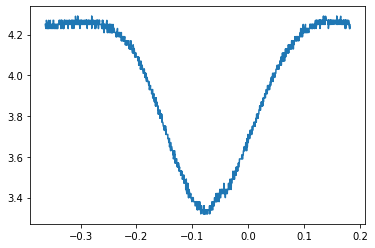

In [ ]:
import matplotlib.pyplot as plt

plt.plot(X,y)

In [ ]:
#X = 2 * np.random.randn(100, 5)
data_num=100
size=4
#X = 2 * np.random.randn(100, 5)
#X=np.random.choice([-1, 1], size=(data_num, size, size))
#print(X[0])
#y = np.cos(X[:, 3]) #+ X[:, 0] ** 2 - (0.5*X[:, 2])
'''y = np.zeros((data_num, size, int(size/2)))
print(y.shape)
for i in range (data_num):
  lat=RG_decimation(X[i])
  y[i] = lat'''
#model = PySRRegressor(binary_operators=["+", "-", "*", "/"])

'y = np.zeros((data_num, size, int(size/2)))\nprint(y.shape)\nfor i in range (data_num):\n  lat=RG_decimation(X[i])\n  y[i] = lat'

In [ ]:
from pysr import PySRRegressor
model = PySRRegressor(
    niterations=5,
    binary_operators=["+", "-", "*", "/"],
    unary_operators=[
        "cos",
        "exp",
        "sin",
        "inv(x) = 1/x",  # Custom operator (julia syntax)
    ],
    model_selection="best",
    loss="loss(x, y) = (x - y)^2",  # Custom loss function (julia syntax)
    batching = True,
    batchSize = 100
)


In [10]:
model.fit(X, y)

PySRRegressor.equations = [
	    pick     score                                           equation  \
	0         0.000000                                          3.9570515   
	1         0.078606                              (3.8932116 / cos(x0))   
	2         0.100286                 (4.7688107 - cos(x0 * -3.5116084))   
	3         0.005336                (4.765724 - cos(sin(x0) * 3.58376))   
	4         0.456883         (x0 - ((cos(x0) * 17.72494) + -21.482964))   
	5         0.445390  (cos(cos((x0 - -0.5156789) / 0.1408587)) - -3....   
	6         1.235151  (exp(cos(cos((x0 / 0.13244656) + 0.55321264)))...   
	7   >>>>  1.710561  (cos(cos((x0 - 1.1303052) / 0.09556082) + 0.47...   
	8         0.231785  (cos(sin(cos((x0 - -1.3294694) / 0.080151066))...   
	9         0.057814  (cos(sin(cos(cos(x0 - 1.2529254) / 0.07762672)...   
	10        0.000615  (cos(sin(cos(cos(sin(x0) - 1.2528056) / -0.077...   
	11        0.907877  exp(cos(exp(cos(-0.7438716 - (sin(sin(x0)) / 0...   
	
	       

In [23]:
print(model.equations.sympy_format[7])

cos(cos(10.4645397559376*x0 - 11.828123701743) + 0.472653) + 3.2933707


In [22]:
from matplotlib import pyplot as plt
plt.scatter(y[:], model(X)[:,0])
plt.xlabel('Truth')
plt.ylabel('Prediction')
plt.show()

TypeError: ignored